# <b> PROJECT
## Classification and Visualization on Damaged Buildings with Different CNN MODELS


### Overview
The latest hurricane - Hurricane Iota, had 61 total fatalities, and 41 are still missing. After a hurricane, damage assessment is vital to the relief helpers and first responders so that resources and help can be planned and allocated appropriately. One way to measure the damage is to detect and quantify the number of damaged buildings, usually done by driving around the affected area and noting down manually. This process can be labor-intensive and time-consuming and not the most efficient method as well. Hence in this project, we will classify buildings between damaged and not damaged buildings using the satellite imagery data provided. 

The data that is provided has the following subfolders:  

- train_another: the training data; 5000 images of each class(damage/no damage)

- validation_another: the validation data; 1000 images of each class(damage/no damage)

- test_another: the unbalanced test data; 8000/1000 images of damaged/undamaged classes

- test: the balanced test data; 1000 images of each class(damage/no damage)

Note: The images provided are RGB and have size 128x128

### Approach
For initial implementation we want to classify buildings into two categories, damaged and no damage. Our goal is to do the following. 
1. Use 10,000 images of size 128x128 for training our Convolutional neural network to correctly predict if the building has sustained any damages. 
2. Use the 1000 images (per class) of the same image size for validation 
3. For testing purposes we have used 3 datasets. 
    1. We have an unbalanced test data set with 8000/1000 (damage/nodamage) images. 
    2. We have also used another test data set for final accuracy with 1000 images. 

### Libraries used
For this project, mainly the following libraries are used:
* `numpy`: Basic mathematical framework
* `tensorflow`: ANN library, our models are built based on it (
* `matplolib`: Viewing images and charting data
* `tf_keras_vis`: For visualizing saliency maps

## Imports

In [1]:
#RUN THIS CELL
!pip -q install tf_keras_vis
!pip -q install tensorflow-addons

     |████████████████████████████████| 53 kB 1.5 MB/s 
     |████████████████████████████████| 1.1 MB 9.1 MB/s 


In [2]:
#RUN THIS CELL
import os
import pathlib
import requests
from IPython.core.display import HTML

working_dir = pathlib.Path().absolute()
# Uncomment the line below to help debug if the path to included images don't show
#print(working_dir)
os.chdir(working_dir)

In [172]:
import os
import certifi
import urllib3  # For handling https certificate verification 
import requests
import zipfile
import shutil
import json
import time
import sys
import cv2
import multiprocessing


import numpy as np
from numpy import random
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import pyplot

from prettytable import PrettyTable
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

from scipy.signal import convolve2d
import scipy.ndimage as ndimage
import subprocess
from PIL import Image
from sklearn.decomposition import PCA

%matplotlib inline

In [130]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

from tensorflow.keras import optimizers, regularizers, losses
from tensorflow.keras.models import Sequential, Model, save_model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization, Input, UpSampling2D, Conv2DTranspose, Reshape, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import  array_to_img, img_to_array, load_img 

#Some imports for getting the CIFAR-10 dataset and for help with visualization*]
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.scorecam import Scorecam

from tensorflow.keras.backend import clear_session


In [5]:
# Pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

#My helper functions

def sizer(y): #gives figsize in golden ratio
    x = y*1.618 #golden ratio
    return (x, y)

plt.style.use('seaborn-whitegrid')

%matplotlib inline

import warnings
# warnings.filterwarnings(action='once')
# warnings.filterwarnings('ignore')

In [6]:
# Plotting number of params v/s number of filters
# Run this cell for more readable visuals 
large = 22; med = 18; small = 13
params = {'axes.titlesize': large,
          'legend.fontsize': small,
          'legend.frameon' : True,
          'legend.fancybox' : True,
          'figure.figsize': sizer(6),
          'axes.labelsize': med,
          'axes.linewidth': 1.5,
          'axes.titleweight' : 'bold',
          'axes.titlepad' : 20,
          'axes.edgecolor' : 'black',
          'lines.linewidth' : 2,
          'xtick.labelsize': small,
          'ytick.labelsize': small,
          'figure.titlesize': large,
          'figure.dpi' : 90,
          'figure.frameon' : True,
          'grid.color' : 'grey'}

plt.rcParams.update(params) #for some reason this has to be in a cell of its own
# print(plt.rcParams)


In [7]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Pysical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/datac_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.random.set_seed(2266)

tensorflow version 2.8.2
keras version 2.8.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Pysical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Loading the dataset and viewing some samples

In [8]:
# Getting the dataset from my google drive
# Following creates a directory, downloads the file and unzips it. 
!gdown 19YKJP-4O15PN8-7BWKF_4fWvf8Mt4ep- -O hurricane.zip
!unzip -n -qq hurricane.zip  -d '/content/'

#setting directory path variables
train_dir = 'train_another'
val_dir = 'validation_another'
test_dir = 'test_another' #IMBALANCED test set
test2_dir = 'test' #balanced test set

Downloading...
From: https://drive.google.com/uc?id=19YKJP-4O15PN8-7BWKF_4fWvf8Mt4ep-
To: /content/hurricane.zip
100% 65.9M/65.9M [00:00<00:00, 86.8MB/s]


We deal with the data here using `ImageDataGenerator` to make generator objects. This is for 2 reasons:

1. In those ImageDataGenerators, we can do mutiple transformations, including flipping, zooming, shifting, normalization, and so on.
2. We can apply those generators to original data by calling `flow_from_dicectory`, directly flowing data from folders to generators and not having to load everything in memory.

Note: Generators can be iterated only once. Make fresh generators for different purposes.

In [18]:
#helper function to make data generators for train, validation and two test sets
#use classmode binary categorical or input in this helper function to make fresh data generators
def makeGen(class_mode):
    # for binary, target = [1/0 is not damage?]
    # for categorical, target = [1/0 is damage?, 1/0 is not damage?]
    # for input, target = original image, use in autoencoders

    train_gen = ImageDataGenerator(
            rescale = 1./255, 
            # rotation_range = 60, 
            width_shift_range = 0.1, 
            height_shift_range = 0.1, 
            zoom_range = 0.1, 
            horizontal_flip = True, 
            vertical_flip = True,
            preprocessing_function = lambda output: tfa.image.gaussian_filter2d(output, (3,3), 1)
        )
    # The reason why we apply Gaussian Blur here is that the original Image is of low resolution 
    # and too much noise is included in the image. Gaussian Blur could remove some of noise here.    

    print('Getting balanced train data: ', end = '')
    train_data = train_gen.flow_from_directory(train_dir, batch_size = 32, class_mode = class_mode, color_mode= 'rgb', shuffle = True, target_size = (128, 128))

    #not augmenting the validation and test data
    val_gen = ImageDataGenerator(
            rescale = 1./255
            # , 
            # rotation_range = 60, 
            # width_shift_range = 0.1, 
            # height_shift_range = 0.1, 
            # zoom_range = 0.1, 
            # horizontal_flip = True, 
            # vertical_flip = True, 
            # preprocessing_function = tfa.image.gaussian_filter2d 
    )
    print('Getting balanced validation data: ', end = '')
    val_data = val_gen.flow_from_directory(val_dir, batch_size = 32, class_mode = class_mode, color_mode= 'rgb', shuffle = True, target_size = (128, 128))

    test_gen = ImageDataGenerator(rescale = 1./255)
    print('Getting imbalanced test data: ', end = '')
    test_data = test_gen.flow_from_directory(test_dir, batch_size = 32, class_mode = class_mode, color_mode= 'rgb', shuffle = True, target_size = (128, 128))

    test2_gen = ImageDataGenerator(rescale = 1./255)
    print('Getting balanced test data: ', end = '')
    test2_data = test2_gen.flow_from_directory(test2_dir, batch_size = 32, class_mode = class_mode, color_mode= 'rgb', shuffle = True, target_size = (128, 128))

    return train_data, val_data, test_data, test2_data

In [19]:
#making data generators for EDA
train_data, val_data, test_data, test2_data = makeGen('binary')
# a, _, _, _ = makeGen('binary')
# b, _, _, _ = makeGen('input')

label_dict = train_data.class_indices
print('\nThe 2 classes are:',label_dict)

Getting balanced train data: Found 10000 images belonging to 2 classes.
Getting balanced validation data: Found 2000 images belonging to 2 classes.
Getting imbalanced test data: Found 9000 images belonging to 2 classes.
Getting balanced test data: Found 2000 images belonging to 2 classes.

The 2 classes are: {'damage': 0, 'no_damage': 1}


In [20]:
to_label = {0: 'Damaged', 1: 'Not Damaged'} #dictionary to convert label value to label

In [21]:
# images, labels = train_data.next() #get a batch
# images.shape, labels.shape # ((32, 128, 128, 3), (32,))

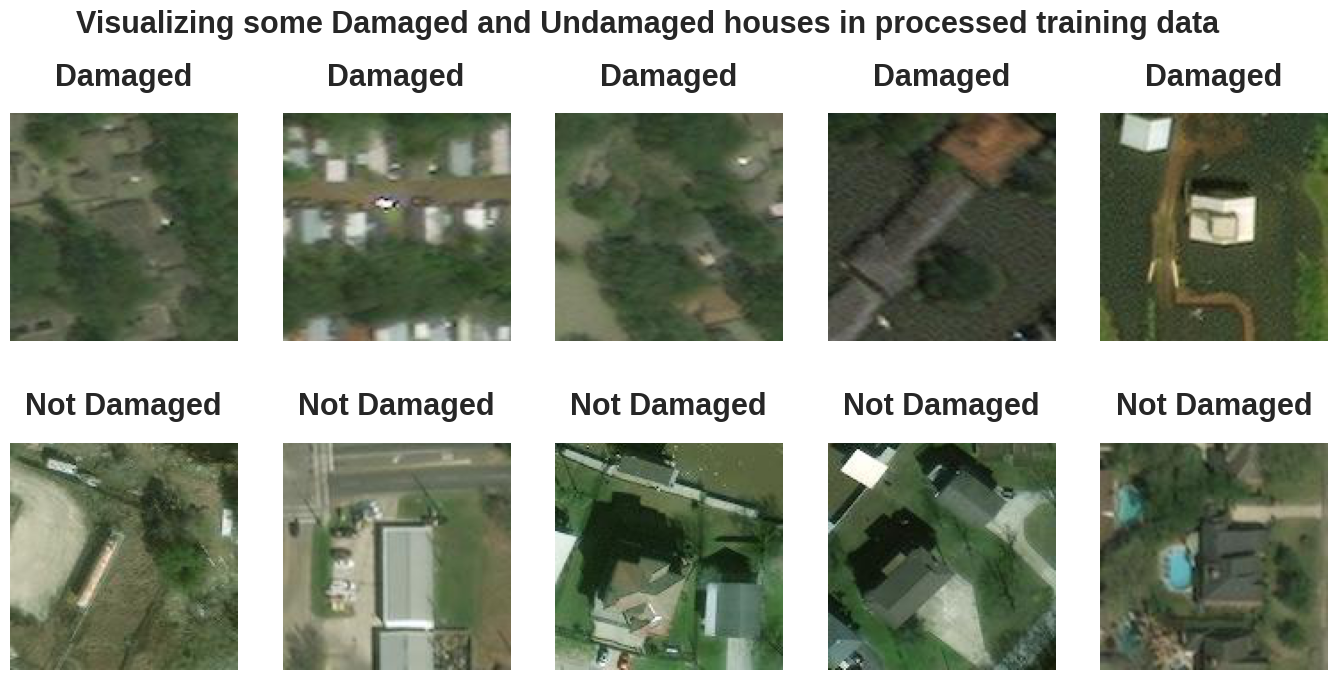

In [22]:
warnings.filterwarnings(action='once')
# Visualizing some images in the training data for both classes
# ensure generators have class_mode = 'binary'
fig, chart = plt.subplots(2, 5, figsize = (17, 8), dpi = 100)
plt.suptitle('Visualizing some Damaged and Undamaged houses in processed training data', fontweight = 'bold')
#to print 5 houses of each class
damage, not_damage = 0, 0
images, labels = train_data.next()
size = train_data.batch_size
idx = 0

while(damage < 5 or not_damage < 5):
    if (damage < 5 and labels[idx] == 0): #get damaged image
        chart[0][damage].imshow(images[idx])
        chart[0][damage].set_title(to_label[labels[idx]])
        chart[0][damage].set_axis_off()
        damage += 1
    elif (not_damage < 5 and labels[idx] == 1): #get not damaged image
        chart[1][not_damage].imshow(images[idx])
        chart[1][not_damage].set_title(to_label[labels[idx]])
        chart[1][not_damage].set_axis_off()
        not_damage += 1
    idx += 1

    if idx == size:
        idx = 0
        images, labels = train_data.next() #getting next batch if cant find enough images in this one
plt.show()

**Observations**

From randomly printed samples above from the processed training set and other pictures:

- It can be seen that damaged houses are most often surrounded by water and some of those damaged house also show visible structural damage. 
- It can also be seen that in undamaged case, the houses can be distinctly recognized by the human eye.
- The effect of gaussian blur is also visible as it has smoothened the image and removed the undulations of foliage and water hopefully making them easier for the CNN to recognize later.

## Evaluating a simple unregularized CNN

In [23]:
#fresh generators before training
input_shape = (128, 128, 3)#images.shape[1:]
train_data, val_data, test_data, test2_data = makeGen('binary')

Getting balanced train data: Found 10000 images belonging to 2 classes.
Getting balanced validation data: Found 2000 images belonging to 2 classes.
Getting imbalanced test data: Found 9000 images belonging to 2 classes.
Getting balanced test data: Found 2000 images belonging to 2 classes.


In [24]:
random.seed(1)
tf.random.set_seed(1)
# Creating an unregularized CNN
model1 = tf.keras.models.Sequential(name = 'unregularized_cnn')

model1.add(Input(shape = input_shape))

# Specify a list of the number of filters for each convolutional layer
cnn_filters = [16,32,16,32]
for n_filters in cnn_filters:
    model1.add(Conv2D(n_filters,activation = 'relu', kernel_size = 3, strides = 2))

model1.add(Flatten())
model1.add(Dense(128, activation = 'relu'))
model1.add(Dense(1, activation = 'sigmoid'))

model1.compile(optimizer = 'Adam', metrics = ['accuracy'], loss = 'binary_crossentropy')
model1.summary()

Model: "unregularized_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 63, 63, 16)        448       
                                                                 
 conv2d_9 (Conv2D)           (None, 31, 31, 32)        4640      
                                                                 
 conv2d_10 (Conv2D)          (None, 15, 15, 16)        4624      
                                                                 
 conv2d_11 (Conv2D)          (None, 7, 7, 32)          4640      
                                                                 
 flatten_2 (Flatten)         (None, 1568)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               200832    
                                                                 
 dense_5 (Dense)             (None, 1)           

In [25]:
# callback = EarlyStopping(monitor = 'val_loss',patience = 5, restore_best_weights = True)
CNN1_history = model1.fit(train_data,epochs=20, shuffle=False, workers = 0, validation_data=val_data) #testing without callback

Epoch 1/10
313/313 [==============================] - 11s 34ms/step - loss: 0.5501 - accuracy: 0.7154 - val_loss: 0.3659 - val_accuracy: 0.8555
Epoch 2/10
313/313 [==============================] - 10s 33ms/step - loss: 0.3125 - accuracy: 0.8758 - val_loss: 0.2590 - val_accuracy: 0.8975
Epoch 3/10
313/313 [==============================] - 11s 34ms/step - loss: 0.2319 - accuracy: 0.9045 - val_loss: 0.2261 - val_accuracy: 0.9100
Epoch 4/10
313/313 [==============================] - 11s 34ms/step - loss: 0.1945 - accuracy: 0.9200 - val_loss: 0.2360 - val_accuracy: 0.9080
Epoch 5/10
313/313 [==============================] - 11s 34ms/step - loss: 0.1682 - accuracy: 0.9289 - val_loss: 0.2384 - val_accuracy: 0.9085
Epoch 6/10
313/313 [==============================] - 11s 34ms/step - loss: 0.1395 - accuracy: 0.9438 - val_loss: 0.1815 - val_accuracy: 0.9285
Epoch 7/10
313/313 [==============================] - 10s 33ms/step - loss: 0.1184 - accuracy: 0.9499 - val_loss: 0.2067 - val_accuracy:

63/63 [==============================] - 2s 27ms/step - loss: 0.1493 - accuracy: 0.9515


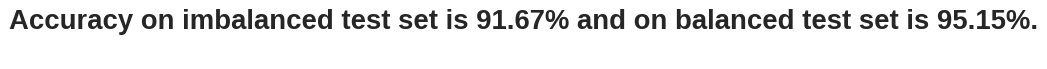

In [35]:
# Evaluate the model on the entire data
CNN_loss1, CNN_acc1 = model1.evaluate(test_data)
# print(f'CNN Test Accuracy: {CNN_acc1 :.3f}')

# Evaluate the model on the entire data
CNN_loss2, CNN_acc2 = model1.evaluate(test2_data)
# print(f'CNN Test Accuracy: {CNN_acc2 :.3f}')

plt.figure(figsize = (6, 0.1))
plt.title(f'Accuracy on imbalanced test set is {100*CNN_acc1:.2f}% and on balanced test set is {100*CNN_acc2:.2f}%.')
plt.axis('off')
plt.show()

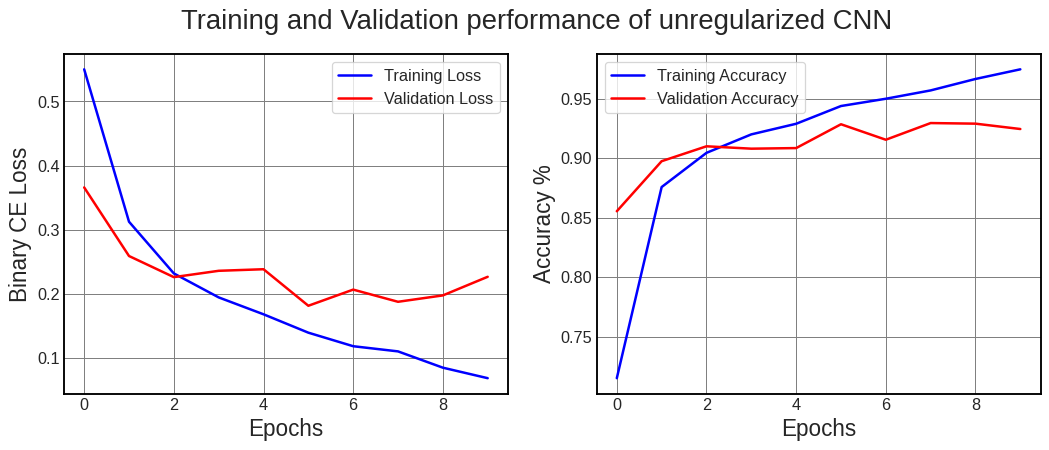

In [29]:
# plot train and val acc as  a function of epochs
# it shows that the model just keeps on overfitting as training goes on
# Got this code from Ed scaffold for A1.2 session 1 scaffold.
fig, ax = plt.subplots(1,2,figsize = (14,5))
ax[0].plot(CNN1_history.history['loss'],color='blue',label = 'Training Loss')
ax[0].plot(CNN1_history.history['val_loss'],color='red',label = 'Validation Loss')
ax[1].plot(CNN1_history.history['accuracy'],color='blue',label = 'Training Accuracy')
ax[1].plot(CNN1_history.history['val_accuracy'],color='red',label = 'Validation Accuracy')
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs');
ax[0].set_ylabel('Binary CE Loss')
ax[1].set_ylabel('Accuracy %');
fig.suptitle('Training and Validation performance of unregularized CNN')
plt.show()

In [32]:
save_model(model1, 'unreg')
!zip -r unreg.zip 'unreg'

INFO:tensorflow:Assets written to: unreg/assets


INFO:tensorflow:Assets written to: unreg/assets


  adding: unreg/ (stored 0%)
  adding: unreg/saved_model.pb (deflated 88%)
  adding: unreg/variables/ (stored 0%)
  adding: unreg/variables/variables.index (deflated 68%)
  adding: unreg/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: unreg/assets/ (stored 0%)
  adding: unreg/keras_metadata.pb (deflated 92%)


In [165]:
 def get_feature_maps(model, layer_id, input_image): #taking the code from homework 2 notebook
    model_ = Model(inputs=[model.input], outputs=[model.layers[layer_id].output])
    return model_.predict(np.expand_dims(input_image, axis=0))[0,:,:,:].transpose((2,0,1))

 def makefeat(model1, img_random):
    convIdx = []
    for i, layer in enumerate(model1.layers):
        if layer.__class__.__name__ == 'Conv2D':
            convIdx.append(i)
            
    for random_layer in convIdx:
        feature_maps = get_feature_maps(model1, random_layer, img_random)
        random_map_idx = random.randint(0, feature_maps.shape[0], size = 16)

        fig, ax = plt.subplots(4, 4, figsize = (4, 4), dpi = 90)

        for i, chart in enumerate(ax.flatten()):
            select_idx = random_map_idx[i]
            select_map = feature_maps[select_idx, :, :]
            chart.imshow(select_map, cmap = 'gray')
            chart.set_axis_off()

        fig.suptitle(f'Randomly selected 16 activation maps from {model1.layers[random_layer].name} layer', y = 0.92, fontsize = 10)
        fig.show()

In [167]:
images, labels = test_data.next()

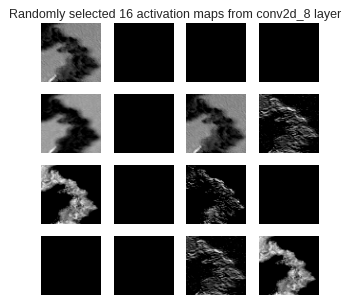

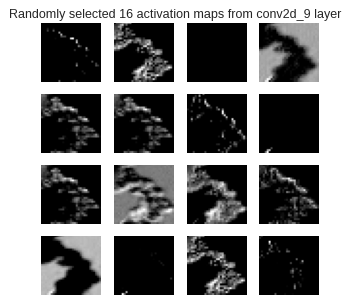

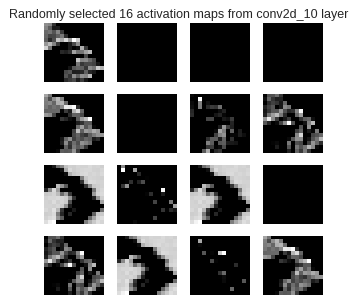

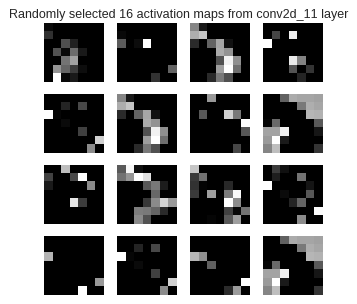

In [169]:
#showing activation maps for unregularized CNN
warnings.filterwarnings('ignore')
makefeat(model1, images[0])

**Inference**

The plots of randomly chosed activation maps from all convolution layers (from bottom to top) were shown to give a better insight on what the CNN is 'seeing'.

The lower layers see the whole image and perform simple detections like edges, lines and corners. The upper maps are more sparse and are learning higher level features. The topmost layer activation maps are very abstract, showing that as we go deeper into the network, the upper layers are learning more high level features (like object type and location) and looking at the image as a whole.

## Evaluating a regularized CNN

In [158]:
#fresh generators before training
input_shape = (128, 128, 3)#images.shape[1:]
train_data, val_data, test_data, test2_data = makeGen('binary')

Getting balanced train data: Found 10000 images belonging to 2 classes.
Getting balanced validation data: Found 2000 images belonging to 2 classes.
Getting imbalanced test data: Found 9000 images belonging to 2 classes.
Getting balanced test data: Found 2000 images belonging to 2 classes.


In [36]:
# Making a CNN regularized with maxpooling and dropout layers
CNN2 = tf.keras.models.Sequential(name="regularized_cnn")

kernel_size = (3,3)
pool_kernel = (2,2)

CNN2.add(Conv2D(16, kernel_size, padding='same', activation = 'relu', input_shape= input_shape ))
CNN2.add(Conv2D(16, kernel_size, padding='same', activation = 'relu'))
CNN2.add(MaxPooling2D(pool_kernel))
CNN2.add(Conv2D(32, kernel_size, padding='same', activation='relu'))
CNN2.add(Conv2D(32, kernel_size, padding='same', activation='relu'))
CNN2.add(MaxPooling2D(pool_kernel))
CNN2.add(Conv2D(64, kernel_size, padding='same', activation='relu'))
CNN2.add(Conv2D(64, kernel_size, padding='same', activation='relu'))
CNN2.add(MaxPooling2D(pool_kernel))
CNN2.add(MaxPooling2D(pool_kernel))
CNN2.add(Flatten())

CNN2.add(Dense(512, activation = 'relu'))
CNN2.add(Dropout(0.2))
CNN2.add(Dense(64, activation='relu'))
CNN2.add(Dropout(0.2))
CNN2.add(Dense(1, activation='sigmoid'))

CNN2.compile(optimizer = tf.keras.optimizers.Adam(), loss= tf.keras.losses.BinaryCrossentropy(), metrics = ['accuracy'])

CNN2.summary()

Model: "regularized_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 128, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_14 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 conv2d_15 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                               

In [37]:
callback = EarlyStopping(monitor = 'val_loss',patience = 5, restore_best_weights = True) #low patience because training takes a long time
CNN2_history = CNN2.fit(train_data,epochs=20, shuffle=False, workers=0,validation_data=val_data, callbacks= [callback])

Epoch 1/20
313/313 [==============================] - 15s 45ms/step - loss: 0.4107 - accuracy: 0.7947 - val_loss: 0.3249 - val_accuracy: 0.8695
Epoch 2/20
313/313 [==============================] - 13s 43ms/step - loss: 0.2022 - accuracy: 0.9176 - val_loss: 0.1501 - val_accuracy: 0.9365
Epoch 3/20
313/313 [==============================] - 14s 45ms/step - loss: 0.1558 - accuracy: 0.9383 - val_loss: 0.1506 - val_accuracy: 0.9495
Epoch 4/20
313/313 [==============================] - 13s 43ms/step - loss: 0.1467 - accuracy: 0.9438 - val_loss: 0.1246 - val_accuracy: 0.9510
Epoch 5/20
313/313 [==============================] - 14s 44ms/step - loss: 0.1183 - accuracy: 0.9556 - val_loss: 0.1094 - val_accuracy: 0.9580
Epoch 6/20
313/313 [==============================] - 14s 44ms/step - loss: 0.0964 - accuracy: 0.9640 - val_loss: 0.1063 - val_accuracy: 0.9660
Epoch 7/20
313/313 [==============================] - 14s 44ms/step - loss: 0.0816 - accuracy: 0.9707 - val_loss: 0.0993 - val_accuracy:

63/63 [==============================] - 2s 29ms/step - loss: 0.0807 - accuracy: 0.9665


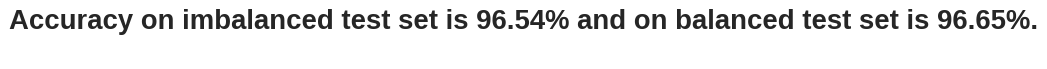

In [159]:
# Evaluate the model on the entire data
CNN2_loss1, CNN2_acc1 = CNN2.evaluate(test_data)
# print(f'CNN Test Accuracy: {CNN_acc1 :.3f}')

# Evaluate the model on the entire data
CNN2_loss2, CNN2_acc2 = CNN2.evaluate(test2_data)
# print(f'CNN Test Accuracy: {CNN_acc2 :.3f}')

plt.figure(figsize = (6, 0.1))
plt.title(f'Accuracy on imbalanced test set is {100*CNN2_acc1:.2f}% and on balanced test set is {100*CNN2_acc2:.2f}%.')
plt.axis('off')
plt.show()

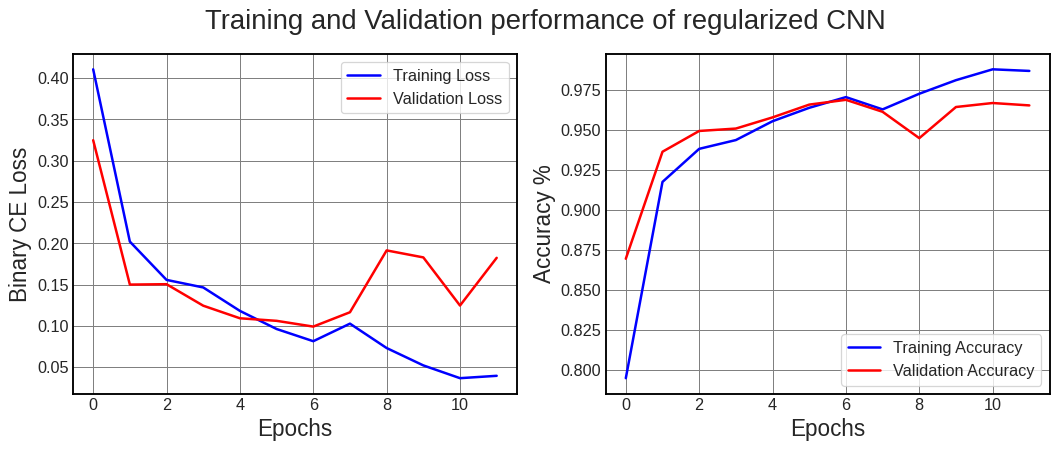

In [42]:
# plot train and val acc as  a function of epochs
# it shows that the model just keeps on overfitting as training goes on
# Got this code from Ed scaffold for A1.2 session 1 scaffold.
fig, ax = plt.subplots(1,2,figsize = (14,5))
ax[0].plot(CNN2_history.history['loss'],color='blue',label = 'Training Loss')
ax[0].plot(CNN2_history.history['val_loss'],color='red',label = 'Validation Loss')
ax[1].plot(CNN2_history.history['accuracy'],color='blue',label = 'Training Accuracy')
ax[1].plot(CNN2_history.history['val_accuracy'],color='red',label = 'Validation Accuracy')
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs');
ax[0].set_ylabel('Binary CE Loss')
ax[1].set_ylabel('Accuracy %');
fig.suptitle('Training and Validation performance of regularized CNN')
plt.show()

In [41]:
save_model(CNN2, 'reg')
!zip -r reg.zip 'reg'

INFO:tensorflow:Assets written to: reg/assets


INFO:tensorflow:Assets written to: reg/assets


  adding: reg/ (stored 0%)
  adding: reg/saved_model.pb (deflated 89%)
  adding: reg/variables/ (stored 0%)
  adding: reg/variables/variables.index (deflated 71%)
  adding: reg/variables/variables.data-00000-of-00001 (deflated 16%)
  adding: reg/assets/ (stored 0%)
  adding: reg/keras_metadata.pb (deflated 93%)


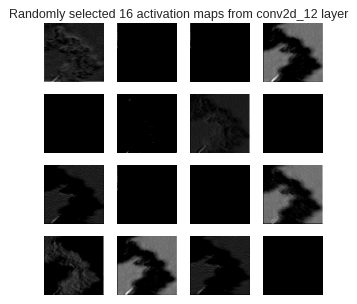

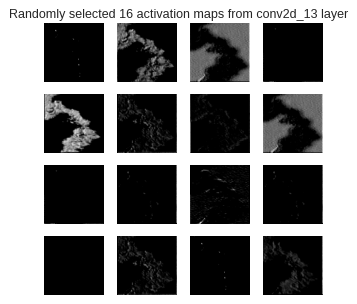

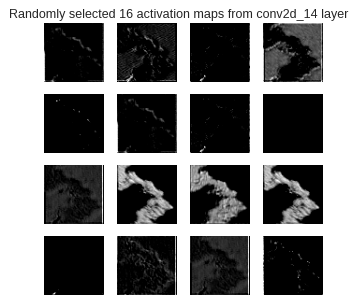

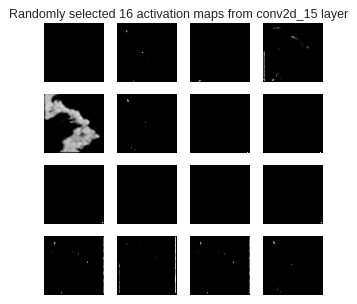

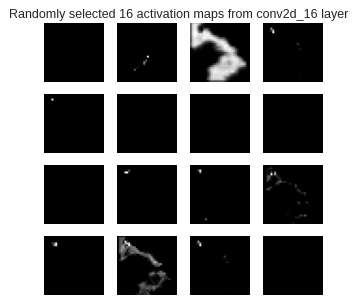

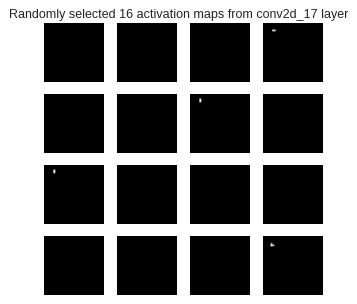

In [171]:
#showing activation maps for regularized CNN on same image as before
warnings.filterwarnings('ignore')
makefeat(CNN2, images[0])

**Inference**

The plots of randomly chosed activation maps from all convolution layers (from bottom to top) were shown to give a better insight on what the CNN is 'seeing'.

The lower layers see the whole image and perform simple detections like edges, lines and corners. The upper maps are more sparse and are learning higher level features. The topmost layer activation maps are almost empty, showing that as we go deeper into the network, the upper layers are learning more high level features (like object type and location) and looking at the image as a whole.

## Designing and training an Autoencoder

In [43]:
#fresh generators before training
input_shape = (128, 128, 3)#images.shape[1:]
train_data, val_data, test_data, test2_data = makeGen('input') #classmode is input for autoencoder

Getting balanced train data: Found 10000 images belonging to 2 classes.
Getting balanced validation data: Found 2000 images belonging to 2 classes.
Getting imbalanced test data: Found 9000 images belonging to 2 classes.
Getting balanced test data: Found 2000 images belonging to 2 classes.


In [98]:
# # autoencoder first attempt
# auto1 = tf.keras.models.Sequential(name = 'autoencoder')

# #encoder
# auto1.add(Conv2D(8, 3, activation = 'relu', padding = 'same', input_shape = (128,128,3) ))
# auto1.add(MaxPooling2D(pool_size = 2))
# auto1.add(Conv2D(16, 3, activation = 'relu', padding = 'same'))
# auto1.add(MaxPooling2D(pool_size = 2))
# auto1.add(MaxPooling2D(pool_size = 2))

# #decoder
# auto1.add(UpSampling2D(size = 2))
# auto1.add(Conv2D(8, 1, activation = 'relu', padding = 'same'))
# auto1.add(UpSampling2D(size = 2))
# auto1.add(Conv2D(3, 1, activation = 'sigmoid', padding = 'same'))
# auto1.add(UpSampling2D(size = 2))

# auto1.summary()

#not using this because it is too inflexible

In [46]:
# autoencoder
auto2 = tf.keras.models.Sequential(name = 'autoencoder')

#encoder
auto2.add(Conv2D(8, 3, activation = 'relu', padding = 'same', input_shape = input_shape ))
auto2.add(MaxPooling2D(pool_size = 2)
auto2.add(Conv2D(16, 3, activation = 'relu', padding = 'same'))
auto2.add(MaxPooling2D(pool_size = 2)
auto2.add(Conv2D(32, 3, activation = 'relu', padding = 'same'))

#decoder
auto2.add(Conv2D(16, 1, activation = 'relu', padding = 'same'))
auto2.add(UpSampling2D(size = 2))
auto2.add(Conv2D(8, 1, activation = 'relu', padding = 'same'))
auto2.add(UpSampling2D(size = 2))
auto2.add(Conv2D(3, 1, activation = 'sigmoid', padding = 'same'))

auto2.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 128, 128, 8)       224       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 8)        0         
 2D)                                                             
                                                                 
 conv2d_25 (Conv2D)          (None, 64, 64, 16)        1168      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_26 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 conv2d_27 (Conv2D)          (None, 32, 32, 16)        

In [47]:
auto2.compile(loss = 'mse', optimizer = 'Adam')

callback = EarlyStopping(monitor = 'val_loss',patience = 5, restore_best_weights = True)
auto_history = auto2.fit(train_data, validation_data = val_data, epochs = 10, workers = 0, shuffle = False, callbacks = [callback] )

Epoch 1/10
313/313 [==============================] - 14s 43ms/step - loss: 0.0112 - val_loss: 0.0042
Epoch 2/10
313/313 [==============================] - 14s 45ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 3/10
313/313 [==============================] - 13s 43ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 4/10
313/313 [==============================] - 14s 45ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 5/10
313/313 [==============================] - 13s 43ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 6/10
313/313 [==============================] - 13s 43ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 7/10
313/313 [==============================] - 13s 43ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 8/10
313/313 [==============================] - 14s 44ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 9/10
313/313 [==============================] - 13s 43ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 10/10
313/313 [==============================] - 13s 43ms/step - loss: 0.001

In [48]:
save_model(auto2, 'auto')
!zip -r auto.zip 'auto'

INFO:tensorflow:Assets written to: auto/assets


INFO:tensorflow:Assets written to: auto/assets


  adding: auto/ (stored 0%)
  adding: auto/saved_model.pb (deflated 89%)
  adding: auto/variables/ (stored 0%)
  adding: auto/variables/variables.index (deflated 68%)
  adding: auto/variables/variables.data-00000-of-00001 (deflated 18%)
  adding: auto/assets/ (stored 0%)
  adding: auto/keras_metadata.pb (deflated 93%)


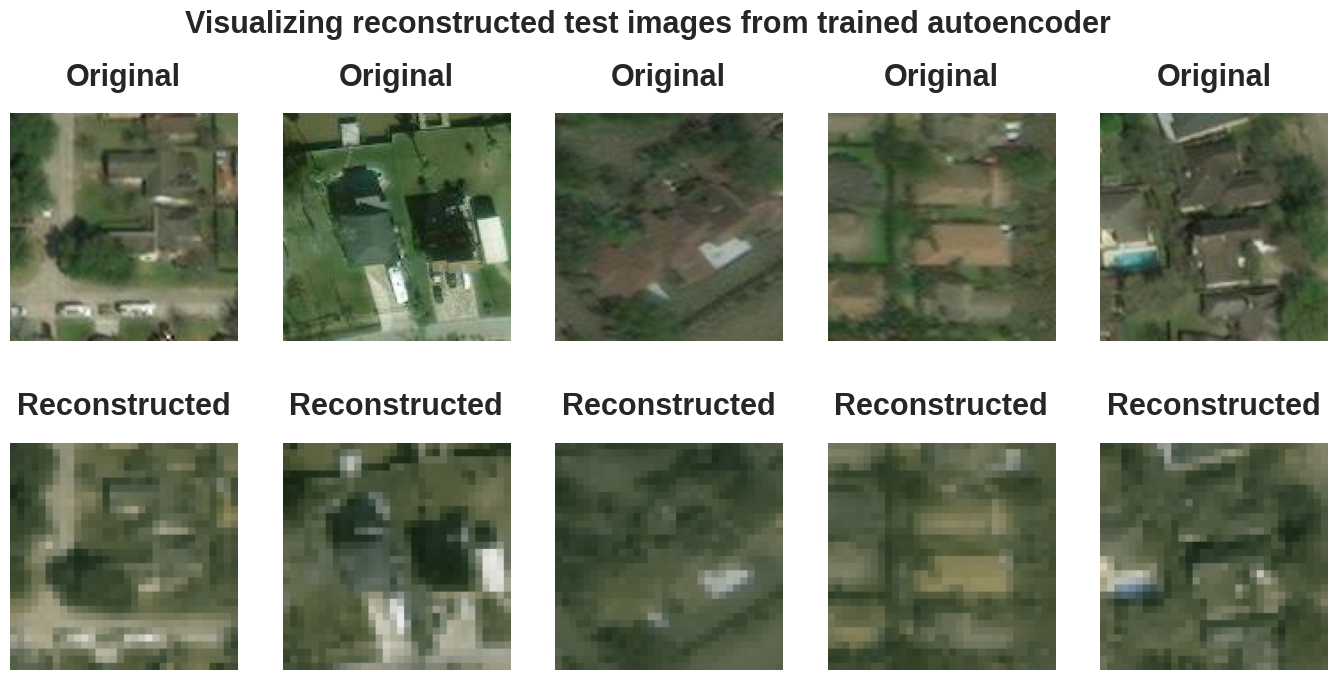

In [52]:
# reconstructing some images using auto encoder
warnings.filterwarnings(action='once')
# Visualizing some images in the test data
# ensure generators have class_mode = 'input'

fig, chart = plt.subplots(2, 5, figsize = (17, 8), dpi = 100)
plt.suptitle('Visualizing reconstructed test images from trained autoencoder', fontweight = 'bold')


images, _ = test2_data.next()
recons = auto2.predict(images)

for idx in range(5):
    chart[0][idx].set_title('Original')
    chart[0][idx].imshow(images[idx])
    chart[0][idx].set_axis_off()

    chart[1][idx].set_title('Reconstructed')
    chart[1][idx].imshow(recons[idx])
    chart[1][idx].set_axis_off()

plt.show()

## Extracting the trained encoder and combining it with a FCNN

In [139]:
auto2.input

<KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'conv2d_24_input')>

In [140]:
#extracting the trained encoder from the trained autoencoder
#autoencoder has 10 layers with 5 in encoder. so encoder ends at output of 5th layer
encoder = Model(inputs=[auto2.input], outputs=[auto2.layers[4].output], name = 'encoder')

#freezing the encoder so it does not get trained
encoder.trainable = True #somehow setting this to false leads to very poor accuracies
enc_out = encoder.output_shape[1:]

encoder.summary()


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24_input (InputLayer  [(None, 128, 128, 3)]    0         
 )                                                               
                                                                 
 conv2d_24 (Conv2D)          (None, 128, 128, 8)       224       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 8)        0         
 2D)                                                             
                                                                 
 conv2d_25 (Conv2D)          (None, 64, 64, 16)        1168      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                           

In [89]:
#fresh generators before training
input_shape = (128, 128, 3)#images.shape[1:]
train_data, val_data, test_data, test2_data = makeGen('binary')

Getting balanced train data: Found 10000 images belonging to 2 classes.
Getting balanced validation data: Found 2000 images belonging to 2 classes.
Getting imbalanced test data: Found 9000 images belonging to 2 classes.
Getting balanced test data: Found 2000 images belonging to 2 classes.


In [90]:
#building a full model and encorporating the pretrained encoder
model3 = Sequential(name = 'CNN_with_encoder')
model3.add(Input(shape = input_shape))
model3.add(encoder)

model3.add(Flatten())
model3.add(Dropout(0.2))
model3.add(Dense(256, activation = 'relu'))
model3.add(Dropout(0.2))
model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(1, activation='sigmoid'))

model3.compile(optimizer = 'Adam', metrics = ['accuracy'], loss = 'binary_crossentropy')
model3.summary()


Model: "CNN_with_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Functional)        (None, 32, 32, 32)        6032      
                                                                 
 flatten_13 (Flatten)        (None, 32768)             0         
                                                                 
 dropout_23 (Dropout)        (None, 32768)             0         
                                                                 
 dense_36 (Dense)            (None, 256)               8388864   
                                                                 
 dropout_24 (Dropout)        (None, 256)               0         
                                                                 
 dense_37 (Dense)            (None, 64)                16448     
                                                                 
 dropout_25 (Dropout)        (None, 64)           

In [91]:
callback = EarlyStopping(monitor = 'val_loss',patience = 5, restore_best_weights = True)
CNN3_history = model3.fit(train_data,epochs=20, shuffle=False, workers = 0, validation_data=val_data, callbacks = [callback])

Epoch 1/20
313/313 [==============================] - 12s 36ms/step - loss: 0.1812 - accuracy: 0.9256 - val_loss: 0.1412 - val_accuracy: 0.9450
Epoch 2/20
313/313 [==============================] - 11s 35ms/step - loss: 0.1125 - accuracy: 0.9552 - val_loss: 0.1389 - val_accuracy: 0.9415
Epoch 3/20
313/313 [==============================] - 11s 35ms/step - loss: 0.0717 - accuracy: 0.9723 - val_loss: 0.1721 - val_accuracy: 0.9460
Epoch 4/20
313/313 [==============================] - 11s 35ms/step - loss: 0.0648 - accuracy: 0.9786 - val_loss: 0.2753 - val_accuracy: 0.9285
Epoch 5/20
313/313 [==============================] - 12s 39ms/step - loss: 0.0380 - accuracy: 0.9852 - val_loss: 0.2243 - val_accuracy: 0.9425
Epoch 6/20
313/313 [==============================] - 11s 35ms/step - loss: 0.0351 - accuracy: 0.9881 - val_loss: 0.2298 - val_accuracy: 0.9520
Epoch 7/20
313/313 [==============================] - 11s 35ms/step - loss: 0.0307 - accuracy: 0.9905 - val_loss: 0.2048 - val_accuracy:

63/63 [==============================] - 2s 26ms/step - loss: 0.1181 - accuracy: 0.9525


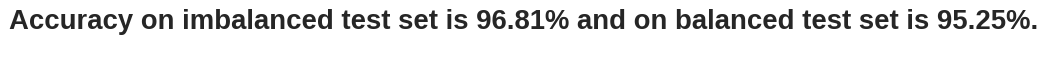

In [95]:
# Evaluate the model on the entire data
CNN3_loss1, CNN3_acc1 = model3.evaluate(test_data)
# print(f'CNN Test Accuracy: {CNN_acc1 :.3f}')

# Evaluate the model on the entire data
CNN3_loss2, CNN3_acc2 = model3.evaluate(test2_data)
# print(f'CNN Test Accuracy: {CNN_acc2 :.3f}')

plt.figure(figsize = (6, 0.1))
plt.title(f'Accuracy on imbalanced test set is {100*CNN3_acc1:.2f}% and on balanced test set is {100*CNN3_acc2:.2f}%.')
plt.axis('off')
plt.show()

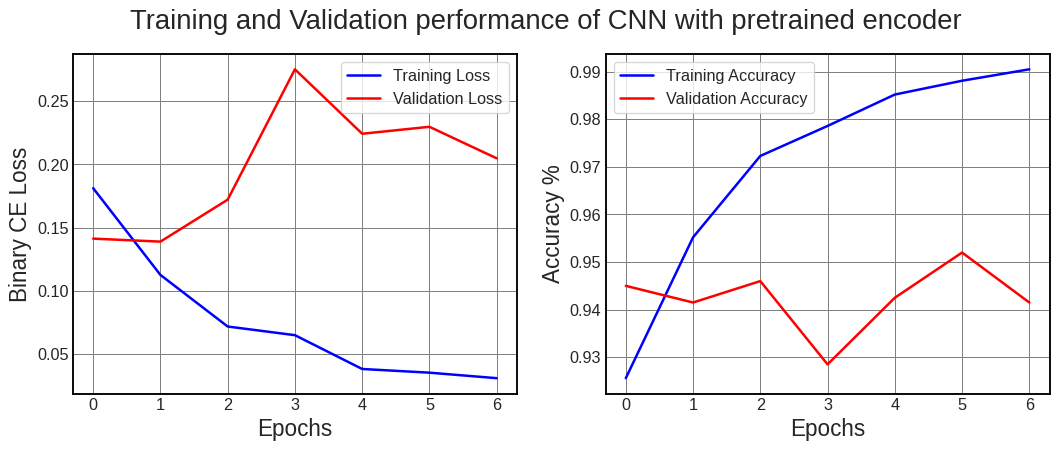

In [156]:
# plot train and val acc as  a function of epochs
# it shows that the model just keeps on overfitting as training goes on
# Got this code from Ed scaffold for A1.2 session 1 scaffold.
fig, ax = plt.subplots(1,2,figsize = (14,5))
ax[0].plot(CNN3_history.history['loss'],color='blue',label = 'Training Loss')
ax[0].plot(CNN3_history.history['val_loss'],color='red',label = 'Validation Loss')
ax[1].plot(CNN3_history.history['accuracy'],color='blue',label = 'Training Accuracy')
ax[1].plot(CNN3_history.history['val_accuracy'],color='red',label = 'Validation Accuracy')
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs');
ax[0].set_ylabel('Binary CE Loss')
ax[1].set_ylabel('Accuracy %');
fig.suptitle('Training and Validation performance of CNN with pretrained encoder')
plt.show()

In [93]:
save_model(model3, 'enc')
!zip -r enc.zip 'enc'

INFO:tensorflow:Assets written to: enc/assets


INFO:tensorflow:Assets written to: enc/assets


  adding: enc/ (stored 0%)
  adding: enc/saved_model.pb (deflated 89%)
  adding: enc/variables/ (stored 0%)
  adding: enc/variables/variables.index (deflated 66%)
  adding: enc/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: enc/assets/ (stored 0%)
  adding: enc/keras_metadata.pb (deflated 93%)


In [173]:
x = PrettyTable()
x.field_names = ["Model", 'Imbalanced Test Acc', 'Balanced Test Acc']
x.add_rows(
    [
        ['Unregularized CNN', f'{100*CNN_acc1:.2f}%',f'{100*CNN_acc2:.2f}%' ],
        ['Regularized CNN', f'{100*CNN2_acc1:.2f}%',f'{100*CNN2_acc2:.2f}%'],
        ['Trained encoder + FCNN', f'{100*CNN3_acc1:.2f}%',f'{100*CNN3_acc2:.2f}%']
    ]
)

print (x)

+------------------------+---------------------+-------------------+
|         Model          | Imbalanced Test Acc | Balanced Test Acc |
+------------------------+---------------------+-------------------+
|   Unregularized CNN    |        91.67%       |       96.65%      |
|    Regularized CNN     |        96.54%       |       96.65%      |
| Trained encoder + FCNN |        96.81%       |       95.25%      |
+------------------------+---------------------+-------------------+


In [ ]:
fpr, tpr, threshold = roc_curve(y_val, y_probs_val)
roc_auc = roc_auc_score(y_val, y_probs_val)

fpr_cc, tpr_cc, threshold_cc = roc_curve(y_val_cc, y_probs_val_cc)
roc_auc_cc = roc_auc_score(y_val_cc, y_probs_val_cc)

fpr_aa, tpr_aa, threshold_aa = roc_curve(y_val_aa, y_probs_val_aa)
roc_auc_aa = roc_auc_score(y_val_aa, y_probs_val_aa)

plt.figure(figsize = sizer(4), dpi = 150)
plt.title('Receiver Operating Characteristics of Caucasian and African American\n')
plt.plot(fpr, tpr, 'r', label = f'ROC total, AUC = {roc_auc:.4f}')
plt.plot(fpr_cc, tpr_cc, 'g', label = f'ROC(CC), AUC = {roc_auc_cc:.4f}')
plt.plot(fpr_aa, tpr_aa, 'b', label = f'ROC(AA), AUC = {roc_auc_aa:.4f}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Visualizing the saliency maps for the 3 models

In [99]:
a = train_data.next()

In [149]:
def makemap(model, img, label):

    score_undam = lambda output: 1 - output[0][0] #because output close to 1 = undamaged
    score_dam = lambda output: output[0][0] #output close to 0 = damaged
    #this is because our model is trained on the binary class mode and score is minimized for making maps

    # Making gradcam and saliency map using code from example at https://pypi.org/project/tf-keras-vis/
    # Also using some code from tf-keras-vis docs at https://keisen.github.io/tf-keras-vis-docs/examples/attentions.html

    # idx = random.choice(np.arange(to_take_test))
    # img = store_room_test[idx][0]
    # deg = store_room_test[idx][1]


    modifier = ReplaceToLinear()
    score = score_undam if label >0.5 else score_dam

    #same as before, creating various saliency maps

    saliency              = Saliency(model, model_modifier = modifier, clone = True)
    saliency_map          = saliency(score, img).squeeze()
    saliency_map_smooth   = saliency(score, img, smooth_samples=20, smooth_noise=0.20).squeeze()

    # scorecam               = Scorecam(model)#, model_modifier = modifier, clone = True)
    # cam                    = scorecam(score, img, penultimate_layer = -1)
    # # cam                   = gradcam(score, img).squeeze()
    # heatmap               = np.uint8(cm.jet(cam)[..., :3] * 255) 
    # #gradcam/scorecam does not work with models that contain a model https://github.com/keisen/tf-keras-vis/issues/63
    # The fix is to deconstruct the model and make it again layer by layer

    # Making plots of all saliency maps like before
    fig, ax = plt.subplots(1, 3, figsize = (14, 5.6))

    ax[0].imshow(img)
    ax[0].set_title(f'Original Image of class = {to_label[label]}', fontsize = 13)
    ax[0].set_axis_off()
    ax[1].imshow(saliency_map_smooth,cmap='CMRmap')
    ax[1].set_axis_off()
    ax[1].set_title('SmoothGrad sailency map', fontsize = 13)
    ax[2].imshow(saliency_map, cmap = 'CMRmap')
    ax[2].set_axis_off()
    
    ax[2].set_title('Saliency map', fontsize = 13)

    # plt.subplots_adjust(top=0.85)
    plt.suptitle(f'CNN saliency maps visualization for test image for {model.name}', fontweight = 'bold')
    plt.show()

In [154]:
a[1]

array([1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1.],
      dtype=float32)

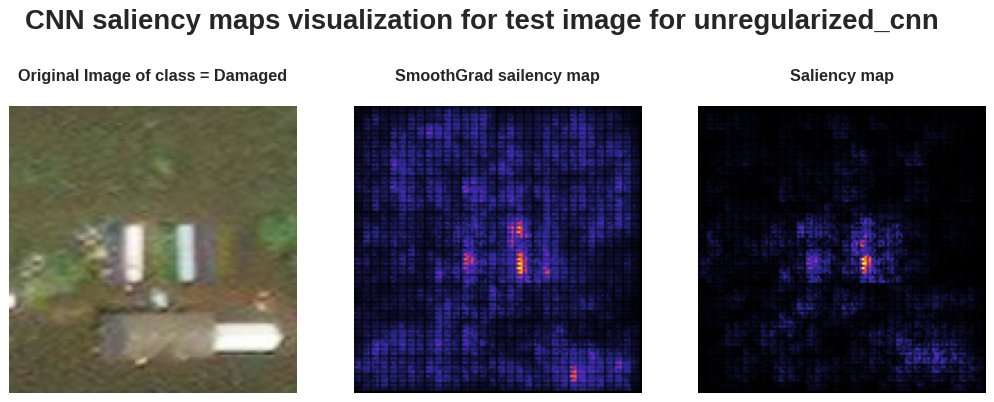

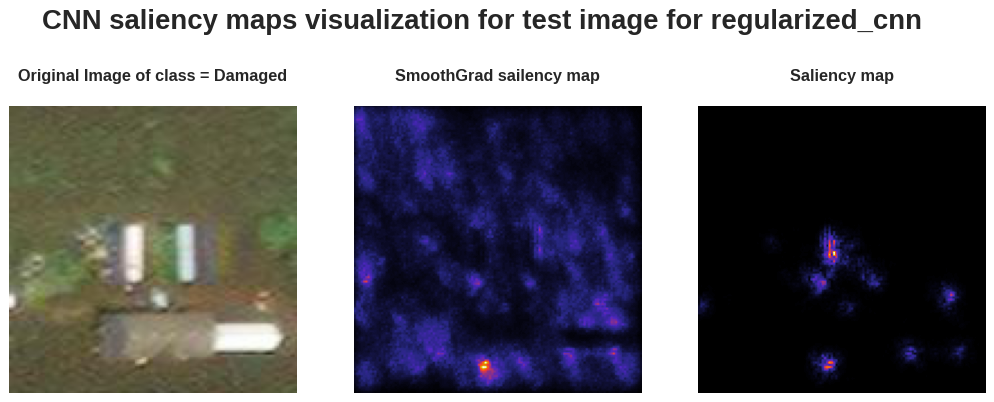

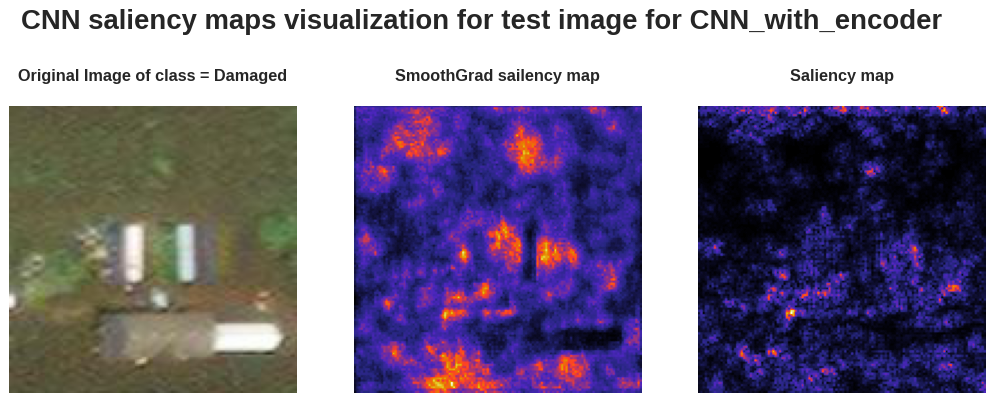

In [152]:
#maps for damaged class
warnings.filterwarnings('ignore')
makemap(model1, a[0][1], a[1][1])
makemap(CNN2, a[0][1], a[1][1])
makemap(model3, a[0][1], a[1][1])

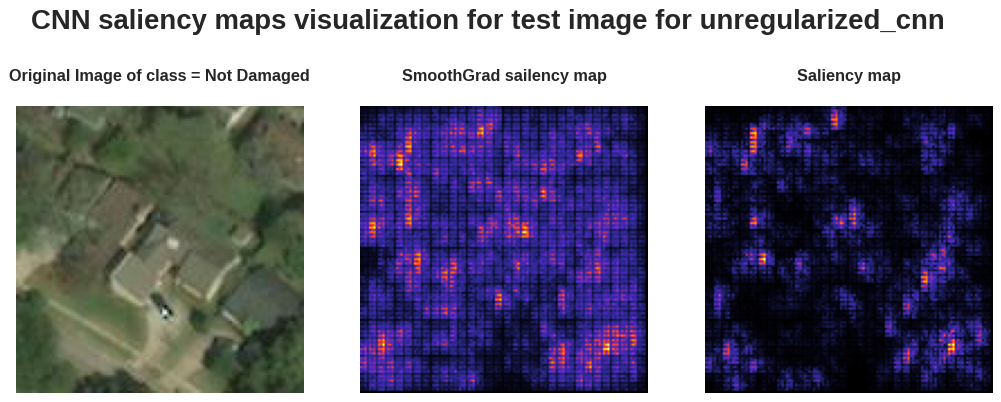

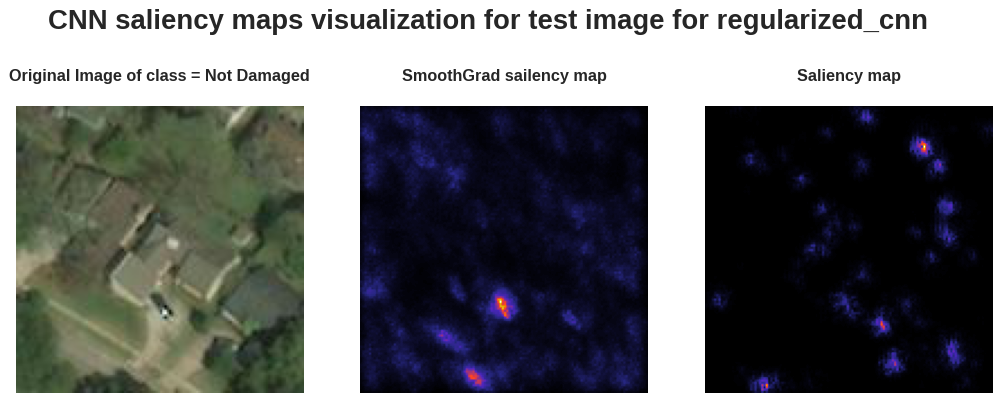

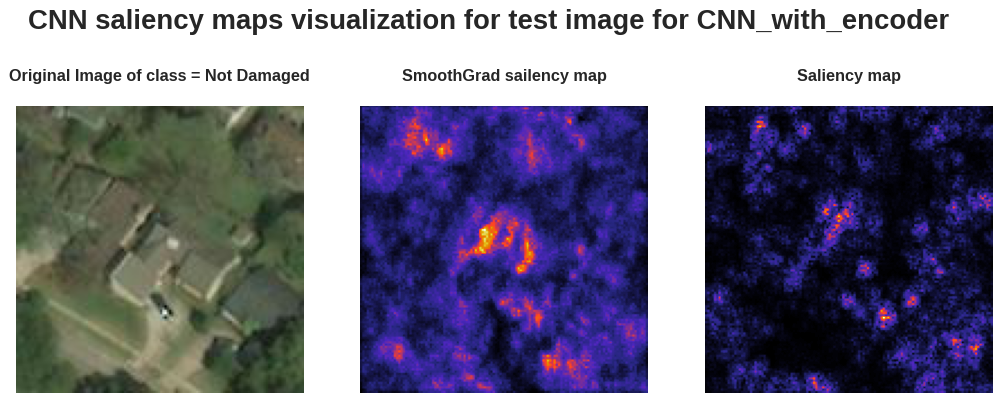

In [155]:
#maps for undamaged class
warnings.filterwarnings('ignore')
makemap(model1, a[0][4], a[1][4])
makemap(CNN2, a[0][4], a[1][4])
makemap(model3, a[0][4], a[1][4])

## Summary

Our simple custom models give a very good performance ~95% on the testing data, which is great for a starting point. We used ImageDataGenerator objects to prevent loading the whole dataset into memory. We have trained 3 kinds of models in this project:

- A vanilla CNN with only convolution layers and dense layers. No regularization. This gave a pleasantly good performance on the balanced test set but a slightly lower performance on the imbalanced set. Understandable as there were no implements in it to make it more robust against class imbalance.

- A deeper CNN with regularization in form of MaxPool layers for convolution and dropout layers for fully connected parts as regularization. This makes the model more robust and improves imbalance performance with accuracy ~96% on both test sets. Furthermore it did not take significantly longer to train because of early stopping callback.

In both these cases, the activation maps were visualized for all Conv2D layers, for the same test image, showing how the feature maps learn higer level features the deeper we go.

- Finally aa convolutional autoencoder with maxpooling regularization was trained and it's reconstruction performance on the test set was visualized. From this, the (already trained) encoder part was extracted and was joined to a newly created fully connected network with dropout regularization. This combined network was trained and it performed comparably to the previous network. This half of the network was already trained, the performance on the imbalanced set actually improved to a max of 96.8%, which is great.

The saliency maps and smoothgrad maps were visualized for all 3 networks for the same test image, (one damaged and one un-damaged class) so see what the model is looking for. It was observed that the encoder + CNN was looking all over the image recognizing the features more robustly.


The models were not given any information of class imbalance and thus the imbalanced test set was a great test of model robustness.


In [174]:
#~fin